## Preparation

In [1]:
# Imports
import json
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt

In [2]:
# Load files
def load_probs(path):
    with open(path, "r") as _file:
        probs = json.load(_file)
    return probs

tiny_mnli_path = "/home/meissner/shortcut-pruning/data/weak_models/tinybert/mnli/tiny-mnli-"
undertrain_mnli_path = "/home/meissner/shortcut-pruning/data/weak_models/undertrained/mnli/undertrain-mnli-"
epochs_comp_path = "/home/meissner/shortcut-pruning/data/weak_models/undertrained/mnli/confidence_exp/epoch-"
tiny_mnlis = [load_probs(tiny_mnli_path + "1" + str(i) + ".json") for i in range(5)]
undertrain_mnlis = [load_probs(undertrain_mnli_path + "1" + str(i) + ".json") for i in range(5)]
undertrain_epochs_comp = [load_probs(epochs_comp_path + str(i) + ".json") for i in range(1,6)]

In [3]:
list(tiny_mnlis[0].items())[:5]

[('0', [0.768073558807373, 0.17574362456798553, 0.056182861328125]),
 ('1', [0.8410807251930237, 0.08569326996803284, 0.07322598248720169]),
 ('2', [0.1369360387325287, 0.665156900882721, 0.1979069858789444]),
 ('3', [0.8453270196914673, 0.07444250583648682, 0.08023039251565933]),
 ('4', [0.8367674350738525, 0.10277853161096573, 0.060453951358795166])]

In [4]:
list(tiny_mnlis[0].values())[:5]

[[0.768073558807373, 0.17574362456798553, 0.056182861328125],
 [0.8410807251930237, 0.08569326996803284, 0.07322598248720169],
 [0.1369360387325287, 0.665156900882721, 0.1979069858789444],
 [0.8453270196914673, 0.07444250583648682, 0.08023039251565933],
 [0.8367674350738525, 0.10277853161096573, 0.060453951358795166]]

In [5]:
tiny_arrays = np.array([list(element.values()) for element in tiny_mnlis])
under_arrays = np.array([list(element.values()) for element in undertrain_mnlis])

In [6]:
tiny_arrays[0][:5]

array([[0.76807356, 0.17574362, 0.05618286],
       [0.84108073, 0.08569327, 0.07322598],
       [0.13693604, 0.6651569 , 0.19790699],
       [0.84532702, 0.07444251, 0.08023039],
       [0.83676744, 0.10277853, 0.06045395]])

## Stability across seeds

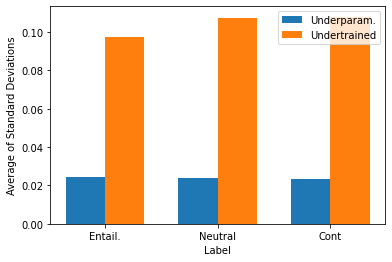

In [7]:
tiny_stdmean, under_stdmean = tiny_arrays.std(axis=0).mean(axis=0), under_arrays.std(axis=0).mean(axis=0)
fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.35
ax.bar(index, tiny_stdmean, bar_width, label="Underparam.")
ax.bar(index+bar_width, under_stdmean, bar_width, label="Undertrained")

ax.set_xlabel('Label')
ax.set_ylabel('Average of Standard Deviations')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(["Entail.", "Neutral", "Cont"])
ax.legend()

plt.show()

## Undertrained vs underparameterized

In [8]:
# Compare average entropy of undertrain vs tiny
tiny_entropies = [np.apply_along_axis(entropy, axis=1, arr=tiny_array) for tiny_array in tiny_arrays]
tiny_entropies = [np.mean(tiny_entropy) for tiny_entropy in tiny_entropies]

In [9]:
under_entropies = [np.apply_along_axis(entropy, axis=1, arr=under_array) for under_array in under_arrays]
under_entropies = [np.mean(under_entropy) for under_entropy in under_entropies]

In [10]:
data = np.array([under_entropies, tiny_entropies]).transpose() # matplotlib wants each vector in one column

In [11]:
data

array([[0.56939415, 0.77563111],
       [0.55566785, 0.80100111],
       [0.68523112, 0.79691538],
       [0.72698146, 0.80803932],
       [0.66274228, 0.78539154]])

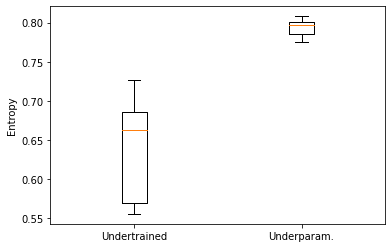

In [12]:
plt.boxplot(data, labels=["Undertrained", "Underparam."])
plt.ylabel("Entropy")
plt.show()

## Undertrained confidence across epochs

In [13]:
# Plot entropy across epochs
comp_arrays = np.array([list(element.values()) for element in undertrain_epochs_comp])
comp_arrays[0].shape

(392702, 3)

In [14]:
comp_entropies = [np.apply_along_axis(entropy, axis=1, arr=array) for array in comp_arrays]
comp_entropies = [np.mean(array) for array in comp_entropies]

In [15]:
# Taken from Wandb
hans_acc = [0.5559, 0.6413, 0.5716, 0.6087, 0.5927]
m_hard_acc = [0.7473, 0.7571, 0.7434, 0.749, 0.7308]

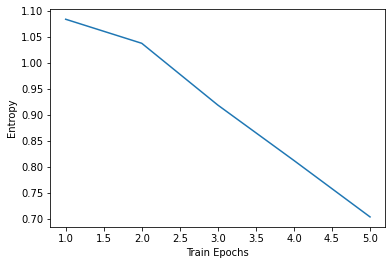

In [16]:
plt.plot(range(1,6), comp_entropies)
# plt.xlim([0,6])
plt.xlabel("Train Epochs")
plt.ylabel("Entropy")
plt.show()

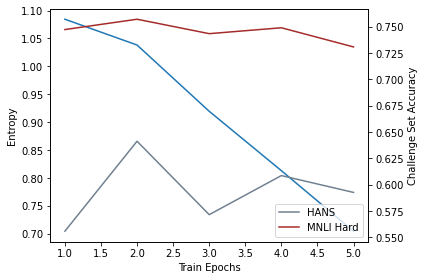

In [17]:
fig, ax1 = plt.subplots()
epochs = range(1,6)

ax1.set_xlabel("Train Epochs")
ax1.set_ylabel('Entropy')
ax1.plot(epochs, comp_entropies)
# ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
ax2.set_ylabel('Challenge Set Accuracy')  # we already handled the x-label with ax1
ax2.plot(epochs, hans_acc, label="HANS", color="slategray")
ax2.plot(epochs, m_hard_acc, label="MNLI Hard", color="brown")
ax2.legend()
# ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Weak model subset performance

In [18]:
with open("/home/meissner/shortcut-pruning/data/subsets/mnli_negation_indices.json", "r") as _file:
    indices = json.loads(_file.read())

In [23]:
train_conts = np.array(indices["train_conts"])
train_ents = np.array(indices["train_ents"])

In [28]:
tiny_cont_mean = (tiny_arrays[:, train_conts, :].argmax(axis=2) == 2).mean()

In [29]:
tiny_ent_mean = (tiny_arrays[:, train_ents, :].argmax(axis=2) == 2).mean()

In [30]:
under_cont_mean = (under_arrays[:, train_conts, :].argmax(axis=2) == 2).mean()

In [31]:
under_ent_mean = (under_arrays[:, train_ents, :].argmax(axis=2) == 2).mean()

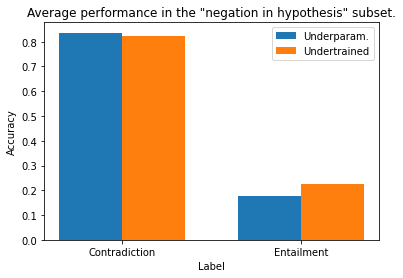

In [36]:
fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.35
ax.bar(index, [tiny_cont_mean, tiny_ent_mean], bar_width, label="Underparam.")
ax.bar(index+bar_width, [under_cont_mean, under_ent_mean], bar_width, label="Undertrained")

ax.set_xlabel('Label')
ax.set_ylabel('Accuracy')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(["Contradiction", "Entailment"])
ax.set_title('Average performance in the "negation in hypothesis" subset.')
ax.legend()

plt.show()